In [1]:
import torch
import sys
sys.path.append("/home/msst/repo/Quantization")
import qlib
DEVICE = 'cuda:0'
from qlib.utils.incoherence_preprocessing.incoherence_process_functions import incoherence_process, incoherence_preprocess, incoherence_preprocess_lukashevich, incoherence_process_lukashevich


import matplotlib.pyplot as plt
def plot_hist(data, bins=32, figsize=(4, 4)):
    data_np = data.flatten().numpy()

    plt.figure(figsize=figsize)
    plt.hist(data_np, bins=bins, edgecolor='black')
    plt.grid(True, alpha=0.3)
    plt.show()

In [15]:
model_name='Llama2-7b-hf'
DTYPE = torch.float16
model = qlib.load_model(model_name=model_name, torch_dtype=DTYPE)

module = model.get_decoder().layers[0].self_attn.q_proj.to(DEVICE)
#module = model.get_decoder().layers[10].mlp.down_proj.to(DEVICE)
w = module.weight.data.float().cuda()
w /= w.std()
#w = torch.randn(4096, 4096).cuda()

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [16]:
# tlut = torch.randn(2**10, 2)

# params = qlib.TrellisQuantizerParams(
# 	T=256,
# 	L=16,
# 	K=2,
# 	V=2,
# 	decode_mode='load_tlut',
# 	tlut_bits=10,
# )

# quantizer = qlib.TrellisQuantizer(
# 	params=params,
# 	tlut=tlut	
# ).cuda()

# w_q, states = quantizer.quantize(w)

# err  = torch.mean(((w_q - w)**2).reshape(-1, 256), dim=-1)
# print(f"error: {err.mean():.3f} ± {err.std():.3f}")

# err.mean(), err.max(), err.median()

In [17]:
sys.path.append("/home/msst/repo/Quantization/microxcaling")

from mx.elemwise_ops import quantize_elemwise_op
from mx.mx_ops import quantize_mx_op
from mx import finalize_mx_specs
from mx.mx_ops import (
    _get_format_params, _reshape_to_blocks, 
    _shared_exponents, _undo_reshape_to_blocks
)


def get_shared_exps(A, mx_specs, axes):
    block_size = mx_specs['block_size']
    if mx_specs["scale_bits"] == 0:
        scale_bits = 8
    else:
        scale_bits = mx_specs["scale_bits"]
    
    axes = [axes] if type(axes) == int else axes
    axes = [x + A.ndim if x < 0 else x for x in axes]    
    shared_exp_axes = [x + 1 for x in axes] if block_size > 0 else axes
            
    A, axes, orig_shape, padded_shape = _reshape_to_blocks(
        A, axes, block_size
    )

    shared_exp = _shared_exponents(
        A, method=mx_specs['shared_exp_method'], axes=shared_exp_axes, ebits=0,
    )

    emax = _get_format_params(mx_specs['w_elem_format'])[2]
    shared_exp = shared_exp - emax
    
    scale_emax = 2**(scale_bits-1) - 1
    shared_exp[shared_exp > scale_emax] = float("NaN")
    shared_exp[shared_exp < -scale_emax] = -scale_emax
    
    return shared_exp



In [18]:
mx_specs = {
    #'w_elem_format': 'fp4_e2m1',
    #'w_elem_format': 'fp6_e2m3',
    'w_elem_format': 'fp6_e3m2',
    #'w_elem_format': 'fp8_e4m3',
    #'w_elem_format': 'int4',
    #'w_elem_format': 'int8',
    #'a_elem_format': 'fp6_e3m2',
    'block_size': 32,
    'bfloat': 16,
    'custom_cuda': False, #True,
    'quantize_backprop': False,
}
mx_specs = finalize_mx_specs(mx_specs)

In [19]:
axes = [-1]
block_size = mx_specs['block_size']
shared_exp = get_shared_exps(w, mx_specs, axes=axes)

_w, axes, orig_shape, padded_shape = _reshape_to_blocks(w, axes, block_size)
_w_scaled = _w / 2**shared_exp
w_scaled = _undo_reshape_to_blocks(_w_scaled, padded_shape, orig_shape, axes)

In [20]:
qis_weight = quantize_mx_op(
    w,
    mx_specs,
    elem_format=mx_specs['w_elem_format'],
    axes=[-1],
    round=mx_specs["round_mx_output"],
)

_qis_weight, axes, orig_shape, padded_shape = _reshape_to_blocks(qis_weight, axes, block_size)
_qis_weight_scaled = _qis_weight / 2**shared_exp

with torch.no_grad():
    uniq_pos = torch.unique(_qis_weight_scaled.abs())



base_codebook_size = 2**10
sample_values = int(base_codebook_size * 1.5)

counts = torch.zeros_like(uniq_pos)
for i, v in enumerate(uniq_pos):
    counts[i] = (_qis_weight_scaled.abs()==v).sum()
    # if v == 0.0:
    #     counts[i] /= 2

freq = (counts / counts.sum()).unsqueeze(0)


freq_2d = freq.T @ freq
counts = (freq_2d * sample_values / freq_2d.sum())
counts = counts.round()
counts = counts.flatten()

unique_cb_h = uniq_pos.repeat(len(uniq_pos), 1)
unique_cb_v = unique_cb_h.T
unique_cb_2d = torch.stack([unique_cb_v, unique_cb_h], dim=0)

unique_cb = unique_cb_2d.reshape(2, -1).T

cb = []
for i, c in enumerate(counts):
    cb += int(c) * [unique_cb[i],]
    
cb = torch.stack(cb)
n_to_remove = len(cb)- base_codebook_size
torch.manual_seed(0)
tlut = cb[torch.randperm(len(cb))][n_to_remove:]

assert list(tlut.shape) == [base_codebook_size, 2]

In [21]:
params = qlib.TrellisQuantizerParams(
    T=256,
    L=16,
    K=2,
    V=2,
    decode_mode='load_tlut',
    tlut_bits=10,
)

quantizer = qlib.TrellisQuantizer(
    params=params,
    tlut=tlut	
).cuda()

w_scaled_q, states = quantizer.quantize(w_scaled)

_w_scaled_q, axes, orig_shape, padded_shape = _reshape_to_blocks(w_scaled_q, axes, block_size)
_w_q = _w_scaled_q * 2**shared_exp
w_q = _undo_reshape_to_blocks(_w_q, padded_shape, orig_shape, axes)

w_q_grouped = w_q.reshape(-1, 256)
w_grouped = w.reshape(-1, 256)

# Вычисляем среднеквадратичную ошибку по каждой группе
err = torch.mean((w_q_grouped - w_grouped) ** 2, dim=-1)
#err  = torch.mean(((w_q - w)**2).reshape(-1, 256), dim=-1)
print(f"error: {err.mean():.3f} ± {err.std():.3f}")


# N(0, 1)
# 0.079 fp4_e2m1
# 0.079 fp6_e2m3
# 0.079 fp6_e3m2
# 0.079 int4

# layers.0.self_attn.q_proj
# 0.075 ± 0.105 fp4_e2m1
# 0.072 ± 0.103 fp6_e2m3
# 0.073 ± 0.103 fp6_e3m2
# 0.069 ± 0.098 int4

# layers.10.mlp.down_proj
# 0.079 ± 0.018 fp4_e2m1
# 0.079 ± 0.019 fp6_e2m3
# 0.079 ± 0.021 fp6_e3m2
# 0.078 ± 0.019 int4


100%|██████████| 256/256 [00:20<00:00, 12.73it/s]


error: 0.073 ± 0.103


In [38]:
top5_err, top5_indices = torch.topk(err, k=5, largest=True)

top5_indices

tensor([38703, 60207, 61263, 61279, 52031], device='cuda:0')

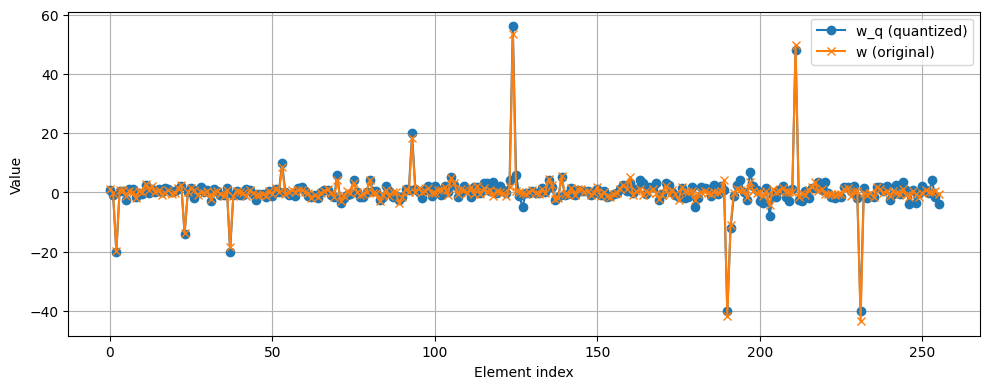

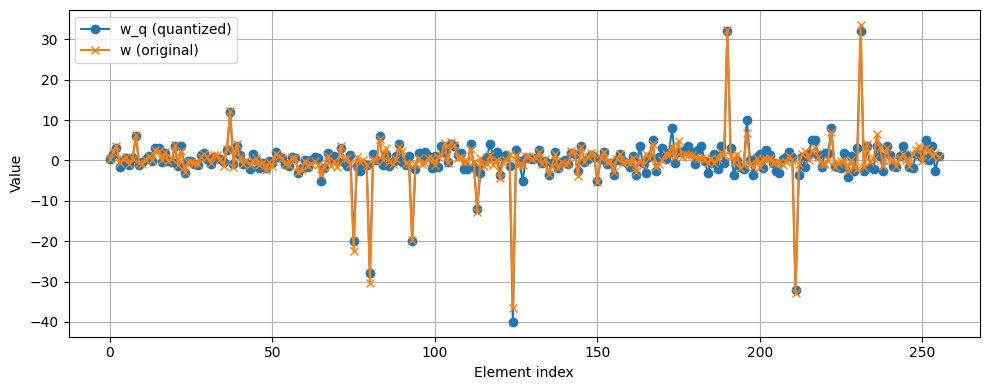

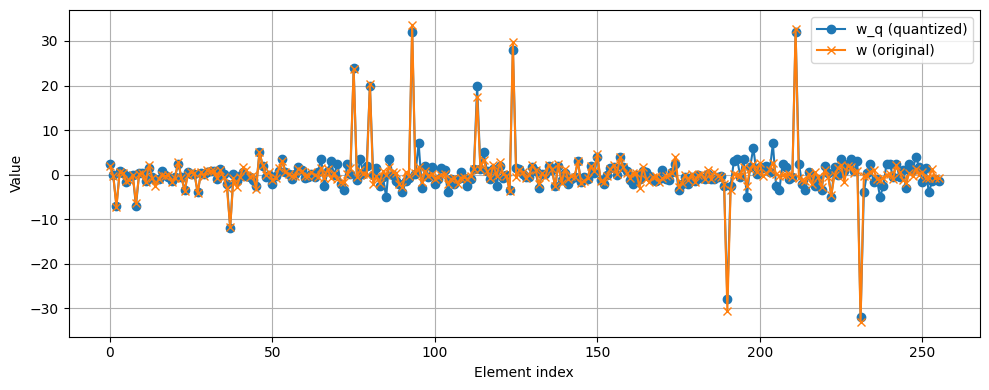

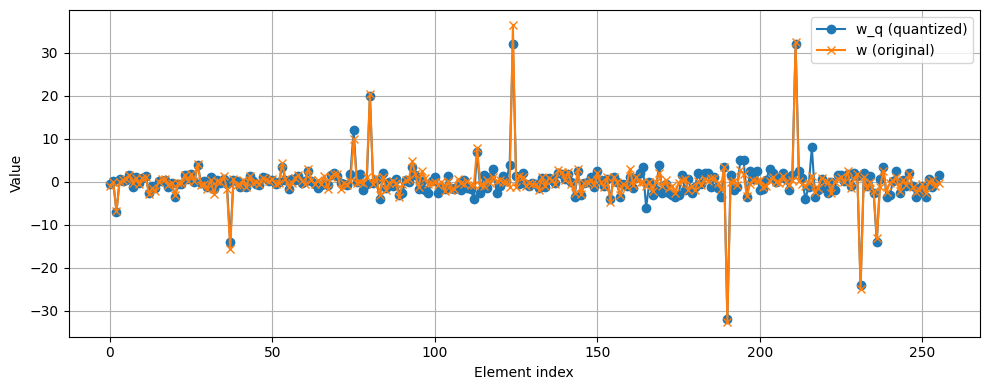

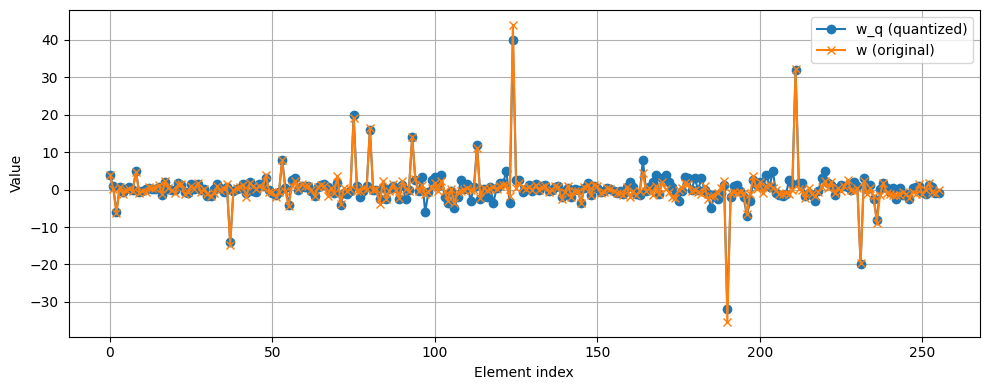

In [41]:
import matplotlib.pyplot as plt

def plot_diff(w, w_q):
	plt.figure(figsize=(10, 4))
	plt.plot(w_q, label='w_q (quantized)', marker='o')
	plt.plot(w, label='w (original)', marker='x')
	plt.xlabel('Element index')
	plt.ylabel('Value')
	plt.legend()
	plt.grid(True)
	plt.tight_layout()
	plt.show()

for idx in top5_indices:
	plot_diff(w_grouped[idx].cpu(), w_q_grouped[idx].cpu())

In [33]:
w_q_grouped[max_err_idx][50:100]

tensor([-1.2500,  1.2500, -0.0000, 10.0000, -0.0625, -1.0000, -0.5000, -1.2500,
         1.5000,  1.7500,  0.3125, -1.2500, -1.5000, -0.8750, -2.0000,  0.1250,
         0.8750,  0.7500, -0.7500, -1.5000,  6.0000, -3.5000, -2.0000, -0.7500,
        -0.5000,  4.0000, -0.0625, -1.5000, -1.7500,  0.2500,  4.0000,  0.3125,
         0.5000, -2.5000, -1.5000,  2.0000,  0.4375, -1.7500, -1.2500, -2.5000,
        -1.7500,  1.2500,  0.7500, 20.0000,  1.2500,  0.1250, -2.0000,  0.7500,
         2.0000, -1.2500], device='cuda:0')

In [34]:
w_grouped[max_err_idx][50:100]

tensor([-5.8412e-01,  1.4762e+00,  2.0429e-03,  8.4403e+00, -4.7771e-01,
         8.8297e-02,  6.2940e-01,  2.4452e-01,  7.8789e-01,  6.7468e-01,
         1.8565e-01, -1.7320e-01, -1.9471e+00, -8.6486e-01, -1.6754e+00,
        -2.8527e-01,  4.1432e-01,  1.0958e+00, -2.2527e-01, -1.5577e+00,
         4.0390e+00, -2.8074e+00, -1.1954e+00,  3.4866e-01, -2.1735e-01,
         3.1334e+00,  2.3546e-01, -1.0641e+00, -5.7733e-01,  2.1282e-01,
         4.2745e+00, -1.6980e-01, -2.1056e-01, -2.9704e+00, -8.1958e-01,
         7.4713e-01, -1.3494e+00, -1.2558e-03, -6.6223e-02, -3.6587e+00,
        -1.5758e+00,  1.0596e+00, -6.7638e-02,  1.8185e+01,  2.3525e-03,
         1.3584e+00,  1.0358e-01,  3.7357e-01,  1.5214e+00, -2.2527e-01],
       device='cuda:0')

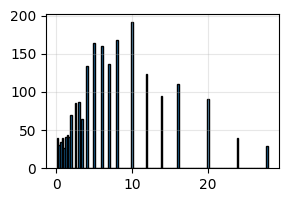

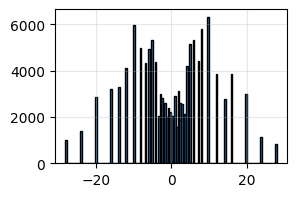

In [11]:
plot_hist(quantizer.tlut.cpu(), bins=128, figsize=(3, 2))
plot_hist(quantizer.lut.cpu(), bins=128, figsize=(3, 2))

In [12]:
raise

RuntimeError: No active exception to reraise

In [3]:
fp_model = qlib.load_model('Llama2-7b-hf', torch_dtype=torch.float16)
W = fp_model.get_submodule('model.layers.0.self_attn.q_proj').weight.data.to(DEVICE)
Wr, SU, SV = incoherence_preprocess(W)

Wr = Wr.reshape(-1, 256)
scales = Wr.std()
Wr_scaled = Wr / scales
Wr_scaled = Wr_scaled.reshape_as(W)


quantizer = qlib.trellis_quantizer(
    L=16,
    K=2,
    V=2,
    T=256,
    decode_mode="LowBitSym", 
    tlut_bits=10
).to(DEVICE)

Wr_scaled_q, states = quantizer.quantize(Wr_scaled)

Wr_scaled_q = Wr_scaled_q.reshape(-1, 256)
Wr_q = Wr_scaled_q * scales
Wr_q = Wr_q.reshape_as(W)

W_q = incoherence_process(Wr_q, SU, SV)

err  = torch.mean(((W_q - W)**2).reshape(-1, 256), dim=-1)
print(f"error: {err.mean():.3e} ± {err.std():.3e}")

#error: 1.512e-05 ± 2.830e-06

#error: 5.038e-05 ± 5.205e-06

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 256/256 [00:20<00:00, 12.79it/s]


error: 1.377e-05 ± 2.306e-06


### With Scaling per group

In [4]:
fp_model = qlib.load_model('Llama2-7b-hf', torch_dtype=torch.float16)
W = fp_model.get_submodule('model.layers.0.self_attn.q_proj').weight.data.to(DEVICE)
Wr, SU, SV = incoherence_preprocess(W)

Wr = Wr.reshape(-1, 256)
scales = Wr.std(dim=-1, keepdim=True)
Wr_scaled = Wr / scales
Wr_scaled = Wr_scaled.reshape_as(W)

quantizer = qlib.trellis_quantizer(
    L=16,
    K=2,
    V=2,
    T=256,
    decode_mode="LowBitSym", 
    tlut_bits=10
).to(DEVICE)

Wr_scaled_q, states = quantizer.quantize(Wr_scaled)
Wr_scaled_q = Wr_scaled_q.reshape(-1, 256)
Wr_q = Wr_scaled_q * scales
Wr_q = Wr_q.reshape_as(W)
W_q = incoherence_process(Wr_q, SU, SV)

err  = torch.mean(((W_q - W)**2).reshape(-1, 256), dim=-1)
print(f"error: {err.mean():.3e} ± {err.std():.3e}")

# error: 5.013e-05 ± 5.153e-06

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 256/256 [00:20<00:00, 12.79it/s]


error: 1.311e-05 ± 1.842e-06


In [5]:
# %%timeit
# reco = quantizer.reconstruct_weight(packed, w.shape)

In [6]:
# %%timeit
# reco_fast = quantizer.reconstruct_weight_fast(packed, w.shape)